In [1]:

import random
import math
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import statistics
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pandas as pd
import random
import math
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import copy
import statistics
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pandas as pd
import geopandas as gpd
import pandas as pd, numpy as np, functools, pickle, os, pathlib
import time
from collections import defaultdict
from datetime import timedelta
from tqdm import tqdm                 



In [2]:
NUM_ROWS = 60000
NUM_AGENTS = 1000
TAXI_BASE_COST = 0.5
BACK_CENTER_COF = 0.2

In [3]:
UNKNOWN_ZONES   = {57,264, 265}          # ID "Unknown" & "Outside NYC"
PU_COLS         = ["PULocationID", "PUlocationID"]   # có thể khác chữ hoa/thường
DO_COLS         = ["DOLocationID", "DOlocationID"]
ZONE_COLS       = PU_COLS + DO_COLS
# ------------------------------------------------------

def load_and_process_data(parquet_file: str) -> pd.DataFrame:
    """
    Đọc 1 parquet row‑group, convert thời gian, 
    bỏ dòng thiếu dữ liệu chính và *loại* mọi record có zone 264/265.
    """
    # 1) load 1 row group (nhẹ RAM)
    reader = pq.ParquetFile(parquet_file)
    table  = reader.read_row_group(0)
    df     = table.to_pandas()

    # 2) down‑sample nếu vượt NUM_ROWS
    # if len(df) > NUM_ROWS:
    #     df = df.head(NUM_ROWS)

    # 3) convert datetime
    datetime_cols = ['request_datetime', 'pickup_datetime',
                     'dropoff_datetime', 'on_scene_datetime']
    for col in datetime_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # 4) drop dòng thiếu dữ liệu quan trọng
    df = df.dropna(subset=['pickup_datetime',
                           'dropoff_datetime',
                           'base_passenger_fare'])

    # 5) loại bỏ trip có zone nằm trong UNKNOWN_ZONES
    #    (tự dò xem cột PU/DO có tồn tại)
    zone_cols_present = [c for c in ZONE_COLS if c in df.columns]
    if zone_cols_present:
        df = df[~df[zone_cols_present].isin(UNKNOWN_ZONES).any(axis=1)]

    return df

# ---- gọi thử ----
df = load_and_process_data(r"data\fhvhv_tripdata_2025-01.parquet")
print(len(df), "rows retained after filtering 264/265/57.")


1001911 rows retained after filtering 264/265/57.


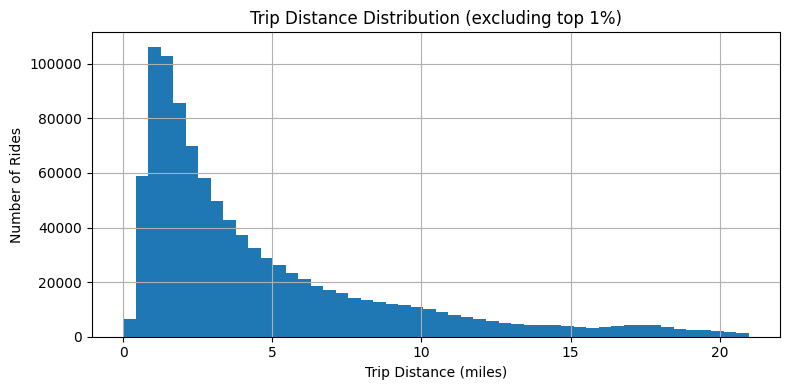

In [17]:
plt.figure(figsize=(8, 4))
plt.hist(df['trip_miles'], bins=50, range=(0, df['trip_miles'].quantile(0.99)))
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Number of Rides')
plt.title('Trip Distance Distribution (excluding top 1%)')
plt.grid(True)
plt.tight_layout()
plt.savefig("trip_distance_distribution.png")
plt.show()


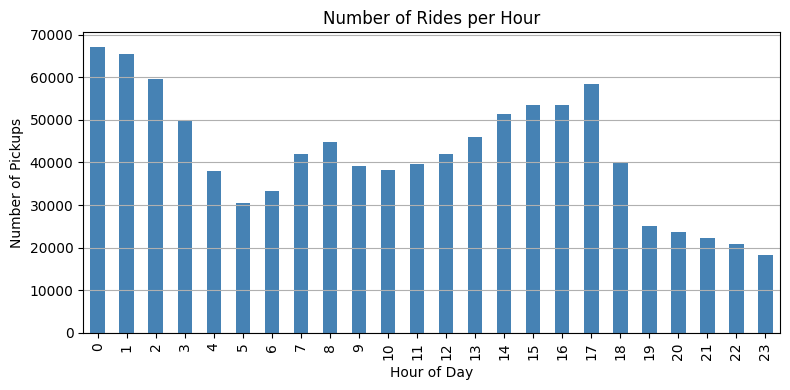

In [18]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour

plt.figure(figsize=(8, 4))
df['hour'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.title('Number of Rides per Hour')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("rides_per_hour.png")
plt.show()


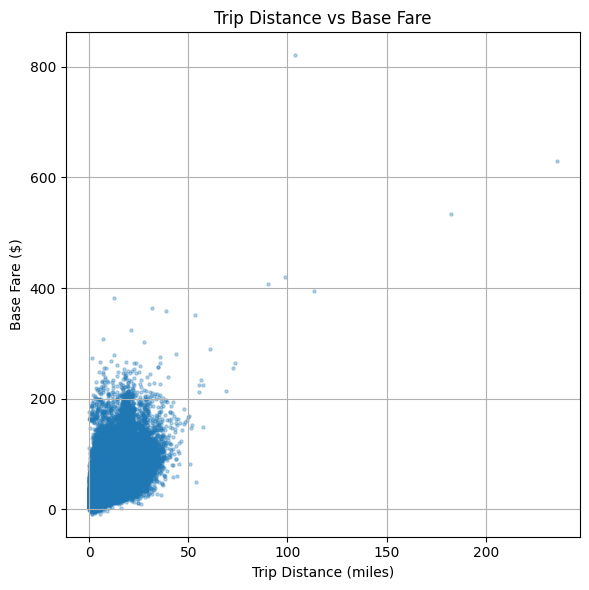

In [19]:
plt.figure(figsize=(6, 6))
plt.scatter(df['trip_miles'], df['base_passenger_fare'], alpha=0.3, s=5)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Base Fare ($)')
plt.title('Trip Distance vs Base Fare')
plt.grid(True)
plt.tight_layout()
plt.savefig("distance_vs_fare.png")
plt.show()


In [ ]:
# Đường dẫn đến shapefile đã giải nén
shapefile_path = r"data\taxi_zones\taxi_zones.shp"

# Đọc shapefile
zones = gpd.read_file(shapefile_path)

# Đọc lookup table
lookup = pd.read_csv(r"data\taxi_zone_lookup.csv")

# Giả sử df là DataFrame chứa dữ liệu chuyến đi với cột 'PULocationID'
# Đếm số lần đón khách tại mỗi LocationID
pickup_counts = df['PULocationID'].value_counts().reset_index()
pickup_counts.columns = ['LocationID', 'pickup_count']

# Gộp dữ liệu với shapefile
zones['LocationID'] = zones['LocationID'].astype(int)
zones = zones.merge(pickup_counts, on='LocationID', how='left')
zones['pickup_count'] = zones['pickup_count'].fillna(0)


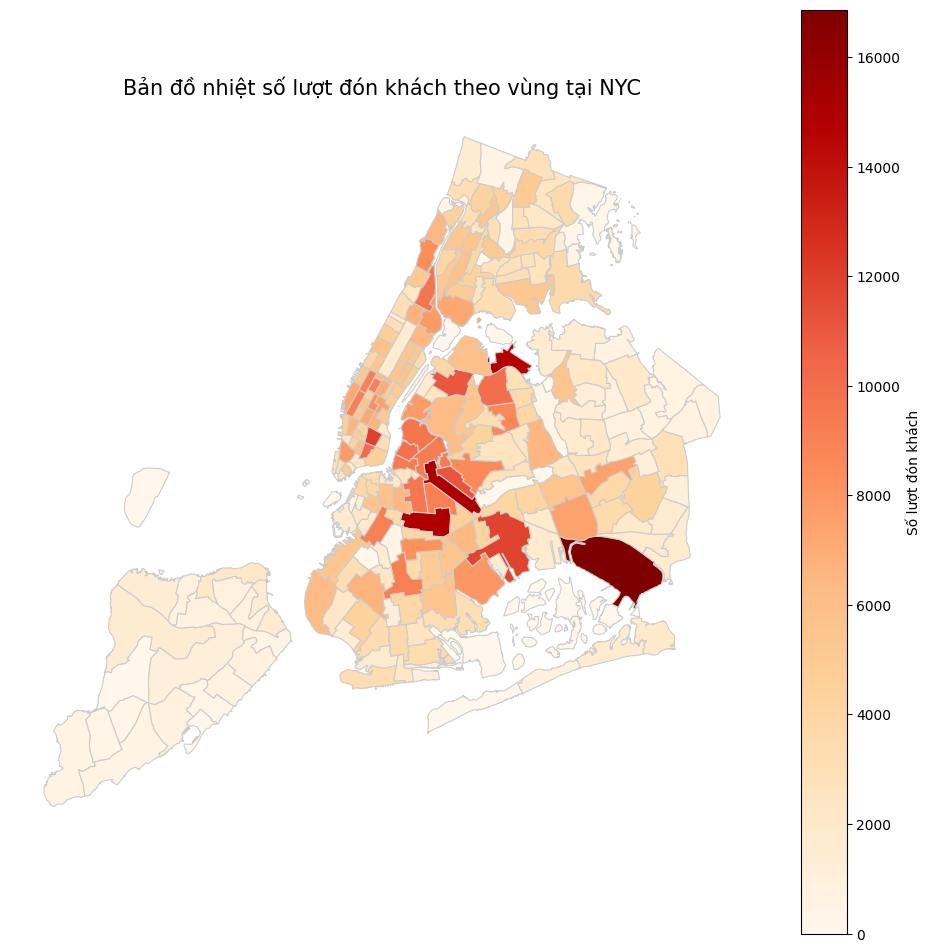

In [25]:
# Thiết lập kích thước hình ảnh
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Vẽ bản đồ nhiệt
zones.plot(column='pickup_count',
           cmap='OrRd',
           linewidth=0.8,
           ax=ax,
           edgecolor='0.8',
           legend=True,
           legend_kwds={'label': "Số lượt đón khách"})

# Thêm tiêu đề
plt.title('Bản đồ nhiệt số lượt đón khách theo vùng tại NYC', fontsize=15)

# Ẩn trục
plt.axis('off')

# Lưu hình ảnh
plt.savefig("pickup_heatmap.png", dpi=300)

# Hiển thị bản đồ
plt.show()


In [4]:
def build_hourly_buckets(df: pd.DataFrame) -> dict:
    """
    Trả về dict: { Timestamp('2024‑03‑01 00:00'): subset_df, ... }.
    Giả thiết df đã có cột pickup_datetime (datetime64).
    """
    df = df.copy()
    df["hour_bin"] = df["pickup_datetime"].dt.floor("1H")
    hourly = {h: group for h, group in df.groupby("hour_bin")}
    return hourly

In [5]:
# --- MỚI: hàm tạo luồng yêu cầu theo giờ --------------------------
def demand_sampler(hour_df: pd.DataFrame,
                   scale: float = 0.1,              # 0.1 = lấy 10 % thật
                   rng: np.random.Generator = np.random.default_rng()):
    """
    Với bộ chuyến của 1 giờ, sinh ra k = Poisson(λ) hành khách.
    λ = len(hour_df) × scale.
    Trả về DataFrame nhỏ (n_hàng = k) để feed vào generate_passengers.
    """
    lam = max(1, int(len(hour_df) * scale))
    k = rng.poisson(lam)
    # Lấy ngẫu nhiên k dòng (nếu ít hơn, lấy tất)
    return hour_df.sample(min(k, len(hour_df)), replace=False, random_state=rng)


In [6]:
# ---------- thông số tuỳ chỉnh ----------
INTRA_ZONE_EXTRA_FEET   = 1000   # dùng cho manhattan_miles nếu muốn khoảng cách > 0
# ---------------------------------------

def build_zone_dict(shapefile="taxi_zones.shp"):
    """
    Returns {zone_id (int): (x, y)} in EPSG:2263 feet.
    Converts LocationID strings → int to avoid KeyError 57, 129, …
    """
    gdf = gpd.read_file(shapefile).to_crs(epsg=2263)

    gdf["LocationID"] = gdf["LocationID"].astype(int)      # <-- key line
    centroids = gdf.geometry.centroid
    coords    = list(zip(centroids.x, centroids.y))

    return dict(zip(gdf["LocationID"], coords))


ZONE = build_zone_dict(r"data\taxi_zones\taxi_zones.shp")   # cache toàn cục một lần

def manhattan_miles(zone_a: int, zone_b: int) -> float:
    """Khoảng cách Manhattan theo mile giữa hai zone centroid.
    Nếu cùng zone: trả về EXTRA_FEET / 5280."""
    if zone_a == zone_b:
        return INTRA_ZONE_EXTRA_FEET / 5280
    xa, ya = ZONE[zone_a]
    xb, yb = ZONE[zone_b]
    feet = abs(xa - xb) + abs(ya - yb)
    return feet / 5280

def eta_minutes(zone_a: int, zone_b: int, speed_mph: float = 20) -> float:
    return manhattan_miles(zone_a, zone_b) / speed_mph * 60

@functools.lru_cache(maxsize=None)
def zone_eta_matrix() -> pd.DataFrame:
    """Ma trận ETA (phút) cho mọi cặp zone, đã áp dụng ngưỡng tối thiểu."""
    zones = sorted(ZONE.keys())
    M = pd.DataFrame(index=zones, columns=zones, dtype=float)
    for i in zones:
        xa, ya = ZONE[i]
        for j in zones:
                xb, yb = ZONE[j]
                feet = abs(xa - xb) + abs(ya - yb)
                M.at[i, j] = feet / 5280 / 20 * 60   # 20 mph → phút
    return M

# Lần đầu chạy
eta_mat = zone_eta_matrix()

# Tuỳ chọn: ghi ra file để lần sau load thẳng
path = pathlib.Path("zone_eta.pkl")
if not path.exists():
    pickle.dump(eta_mat, open(path, "wb"))


In [7]:
def compute_driver_profit(driver_zone: int,
                          pickup_zone: int,
                          dropoff_zone: int,
                          base_fare: float,
                          city_center_zone: int,
                          alpha: float = 1.0,        # hệ số chi phí tới điểm đón
                          beta:  float = 0.2):       # hệ số dead‑head quay về trung tâm
    eta_to_pickup   = eta_minutes(driver_zone,   pickup_zone)     # phút
    eta_to_center   = eta_minutes(dropoff_zone, city_center_zone) # phút
    cost_minutes    = alpha * eta_to_pickup + beta * eta_to_center
    # tuỳ chính sách bạn có thể quy đổi 1 phút = x USD thay vì trừ trực tiếp
    return base_fare - TAXI_BASE_COST*cost_minutes

    
def find_center_location(df):
    # Use the mode of the pickup location (PULocationID) as the center.
    center = df['PULocationID'].mode()[0]
    return center

In [8]:
class Agent:
    def __init__(self, name, current_location):
        self.name = name
        self.current_location = current_location

# Derived class for Drivers, inheriting from Agent
class Driver(Agent):
    def __init__(self, name, current_location):
        super().__init__(name, current_location)
        self.total_income = 0
        # number of rides drivers have picked up
        self.total_rides = 0
        self.preference_ordering = []
        # the passenger they picked up in the previous round
        self.matched_passenger_name = None
        # the locations they have visited
        self.locations = []

    def calculate_preference_ordering_driver(self, passengers, city_center, alpha=1, beta=BACK_CENTER_COF):
        self.preference_ordering = sorted(
            passengers,
            key=lambda passenger: -compute_driver_profit(
                self.current_location,
                passenger.current_location,
                passenger.dropoff_location,
                passenger.WTP,
                city_center,
                alpha,
                beta
            )
        )



# Derived class for Passengers, inheriting from Agent
class Passenger(Agent):
    def __init__(self, name, current_location, dropoff_location, base_fare):
        super().__init__(name, current_location)
        self.dropoff_location = dropoff_location
        self.WTP = base_fare
        self.preference_ordering = []

        self.matched_driver_name = None
    
    def calculate_preference_ordering_passenger(self, drivers, var: float = 1.0):
        """
        passenger.preference_ordering  = danh sách driver, sắp xếp tăng dần theo
        ( khoảng cách/ETA  +  var * (thu nhập đã kiếm) ).
        Khoảng cách dùng ETA (phút) để tự động áp dụng ngưỡng intra‑zone.
        """
        # 1) thu thập dữ liệu cho từng driver
        stats = {
            d: (eta_minutes(d.current_location, self.current_location),
                d.total_income)
            for d in drivers
        }

        # 2) chuẩn hoá hai thang đo về [0,1] để có thể cộng
        scaler = MinMaxScaler()
        etas     = scaler.fit_transform([[v[0]] for v in stats.values()]).ravel()
        incomes  = scaler.fit_transform([[v[1]] for v in stats.values()]).ravel()

        # 3) tính “điểm ưu tiên” = ETA_norm + var * income_norm
        scores = {d: etas[i] + var * incomes[i] for i, d in enumerate(stats)}

        # 4) sắp xếp: driver có điểm thấp nhất (gần & thu nhập thấp) được ưu tiên
        self.preference_ordering = sorted(scores, key=scores.get)

In [9]:


def generate_drivers(df,num_drivers):
    drivers = []
    pickup_locations = df['PULocationID']
    sampled_locations = pickup_locations.sample(n=num_drivers, replace=True).tolist()
    for i in range(0, num_drivers):
        current_location = sampled_locations[i]
        drivers.append(Driver(f"Driver_{i}", current_location))
    return drivers

def generate_passengers(df, num_passengers, num_round):
    passengers = []
    # Use num_round as starting index (1-based)
    start_idx = (num_round - 1) * num_passengers
    end_idx = start_idx + num_passengers
    
    # Get the slice of dataframe based on round number
    df_slice = df.iloc[start_idx:end_idx]
    
    for i, (idx, row) in enumerate(df_slice.iterrows()):
        # Generate random coordinates for current location and dropoff location for passengers
        current_location = row['PULocationID']
        dropoff_location = row['DOLocationID']
        base_fare = row.get('base_passenger_fare', None)
        # Use i to create sequential passenger IDs within each round
        passenger_idx = start_idx + i
        passengers.append(Passenger(f"Passenger_{passenger_idx}", current_location, dropoff_location, base_fare))
    return passengers
# --- MỚI: generate_passengers_from_df -----------------------------
def generate_passengers_from_df(df_subset: pd.DataFrame, timestep: int):
    """
    Bọc lại generate_passengers nhưng dùng kích thước df_subset và không cần num_passengers.
    """
    num = len(df_subset)
    return generate_passengers(df_subset, num, timestep)


def find_center_location(df):
    # Use the mode of the pickup location (PULocationID) as the center.
    center = df['PULocationID'].mode()[0]
    return center

In [10]:
def driver_proposing_matching(drivers, passengers, city_center, var):
    matches = []

    # clear out last round
    for driver in drivers:
        driver.matched_passenger_name = None
        driver.calculate_preference_ordering_driver(passengers, city_center)

    for passenger in passengers:
        passenger.matched_passenger_name = None
        passenger.calculate_preference_ordering_passenger(drivers, var)

    # dicts from names to objects
    driver_dict = {driver.name: driver for driver in drivers}

    passenger_prefs = {passenger.name: {driver.name: i for (i, driver) in enumerate(
        passenger.preference_ordering)} for passenger in passengers}

    # initialize set of unmatched renters
    free_drivers = set(drivers)

    while free_drivers:
        driver = free_drivers.pop()

        for preferred_passenger in driver.preference_ordering:
            if preferred_passenger.matched_driver_name is None:
                preferred_passenger.matched_driver_name = driver.name
                driver.matched_passenger_name = preferred_passenger.name
                break
            else:
                try:
                    current_match_rank = passenger_prefs[preferred_passenger.name][preferred_passenger.matched_driver_name]
                    new_match_rank = passenger_prefs[preferred_passenger.name][driver.name]
                except KeyError:
                    continue  # bỏ qua cặp không hợp lệ

                if new_match_rank < current_match_rank:
                    # If the lender prefers the new renter, make the switch
                    free_drivers.add(
                        driver_dict[preferred_passenger.matched_driver_name])
                    preferred_passenger.matched_driver_name = driver.name
                    driver.matched_passenger_name = preferred_passenger.name
                    # print("matched non-empty")
                    # print(f"non-empty match: {driver.name} matched with {preferred_passenger.name}")
                    break

    matches = [(driver.name, driver.matched_passenger_name)
           for driver in drivers
           if driver.matched_passenger_name is not None]

    return matches



In [11]:
def closest_matches(drivers, passengers, city_center, var):
    # Build a “cost” matrix where cost = –profit (so maximizing profit ↔ minimizing cost)
    cost_matrix = []
    for driver in drivers:
        row = []
        for passenger in passengers:
            profit = compute_driver_profit(
                driver.current_location,
                passenger.current_location,
                passenger.dropoff_location,
                passenger.WTP,
                city_center,
                alpha=1,
                beta=1
            )
            row.append(-profit)
        cost_matrix.append(row)

    cost_matrix = np.array(cost_matrix)

    # Solve the assignment problem (minimize –profit → maximize profit)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Convert indices back to (driver_name, passenger_name)
    matches = [
        (drivers[i].name, passengers[j].name)
        for i, j in zip(row_ind, col_ind)
    ]
    return matches

In [12]:
def simulate_round(drivers, new_passengers, city_center, algo, var):
    passenger_dict = {passenger.name: passenger for passenger in new_passengers}

    new_matches = algo(drivers, new_passengers, city_center, var)

    for match in new_matches:
        for driver in drivers:
            if driver.name == match[0]:
                driver.matched_passenger_name = match[1]
                if driver.matched_passenger_name is not None:
                    passenger = passenger_dict[driver.matched_passenger_name]
                    driver.current_location = passenger.dropoff_location
                    driver.total_income += passenger.WTP
    return new_matches, len(new_matches)

def jains_index(values: np.ndarray) -> float:
    """Jain's Fairness Index for a 1‑D array of non‑negative numbers."""
    values = values.astype(float)
    if values.size == 0 or np.all(values == 0):
        return 1.0                        # everyone equal at zero
    num  = values.sum() ** 2
    denom = values.size * (values ** 2).sum()
    return num / denom

from typing import Union, Sequence

def gini(arr: Union[np.ndarray, Sequence[float]]) -> float:
    """Return Gini coefficient of an income vector."""
    a = np.sort(np.asarray(arr, dtype=float))
    n = a.size
    if n == 0 or a.mean() == 0:
        return 0.0
    diff_sum = np.abs(np.subtract.outer(a, a)).sum()
    return diff_sum / (2 * n**2 * a.mean())

In [13]:
# --- MỚI: simulate_one_day ---------------------------------------
def simulate_one_day(df: pd.DataFrame,
                     num_agents: int,
                     algo_fn,
                     scale: float = 0.1,
                     seed: int = 42):
    """
    Chạy 24 h với chuỗi nhu cầu theo giờ.
    Trả về dict KPI giống simulations cũ để dùng lại logic.
    """
    rng = np.random.default_rng(seed)
    hourly = build_hourly_buckets(df)
    timeline = sorted(hourly.keys())[:24]          # 24 h đầu của file

    city_center = find_center_location(df)
    drivers = generate_drivers(df, num_agents)

    total_matches = 0
    for t_idx, hour in enumerate(tqdm(timeline, desc="Sim 24h")):
        # 1) sinh hành khách giờ này
        new_pass_df = demand_sampler(hourly[hour], scale, rng)
        if new_pass_df.empty:
            continue
        passengers = generate_passengers_from_df(new_pass_df, t_idx + 1)

        # 2) ghép
        matches, match_cnt = simulate_round(drivers, passengers,
                                            city_center, algo_fn, var=0)
        total_matches += match_cnt

    # 3) Tính KPI giống code cũ -----------------------------------
    incomes = np.array([d.total_income for d in drivers])
    revenue = incomes.sum()
    results = {
        "revenue":          revenue,
        "revenue_per_ride": revenue / total_matches if total_matches else 0,
        "mean_income":      incomes.mean(),
        "sd_income":        incomes.std(ddof=1),
        "jfi_income":       jains_index(incomes),
        "gini_income":      gini(incomes),
        "rides":            total_matches
    }
    return results


In [14]:
def simulations(df, NUM_AGENTS, algorithms, scale=0.1):
    results = {}
    for algo_name, algo_func in algorithms.items():
        start = time.perf_counter()
        stats = simulate_one_day(df, NUM_AGENTS, algo_func, scale)
        stats["runtime_sec"] = time.perf_counter() - start
        results[algo_name] = stats
    return results


C:\Users\PC\AppData\Local\Temp\ipykernel_1144\4007491344.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour_bin"] = df["pickup_datetime"].dt.floor("1H")
Sim 24h: 100%|██████████| 24/24 [00:15<00:00,  1.50it/s]
C:\Users\PC\AppData\Local\Temp\ipykernel_1144\4007491344.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour_bin"] = df["pickup_datetime"].dt.floor("1H")
Sim 24h: 100%|██████████| 24/24 [00:01<00:00, 14.98it/s]
C:\Users\PC\AppData\Local\Temp\ipykernel_1144\4007491344.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour_bin"] = df["pickup_datetime"].dt.floor("1H")
Sim 24h: 100%|██████████| 24/24 [00:16<00:00,  1.46it/s]
C:\Users\PC\AppData\Local\Temp\ipykernel_1144\4007491344.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["hour_bin"] 

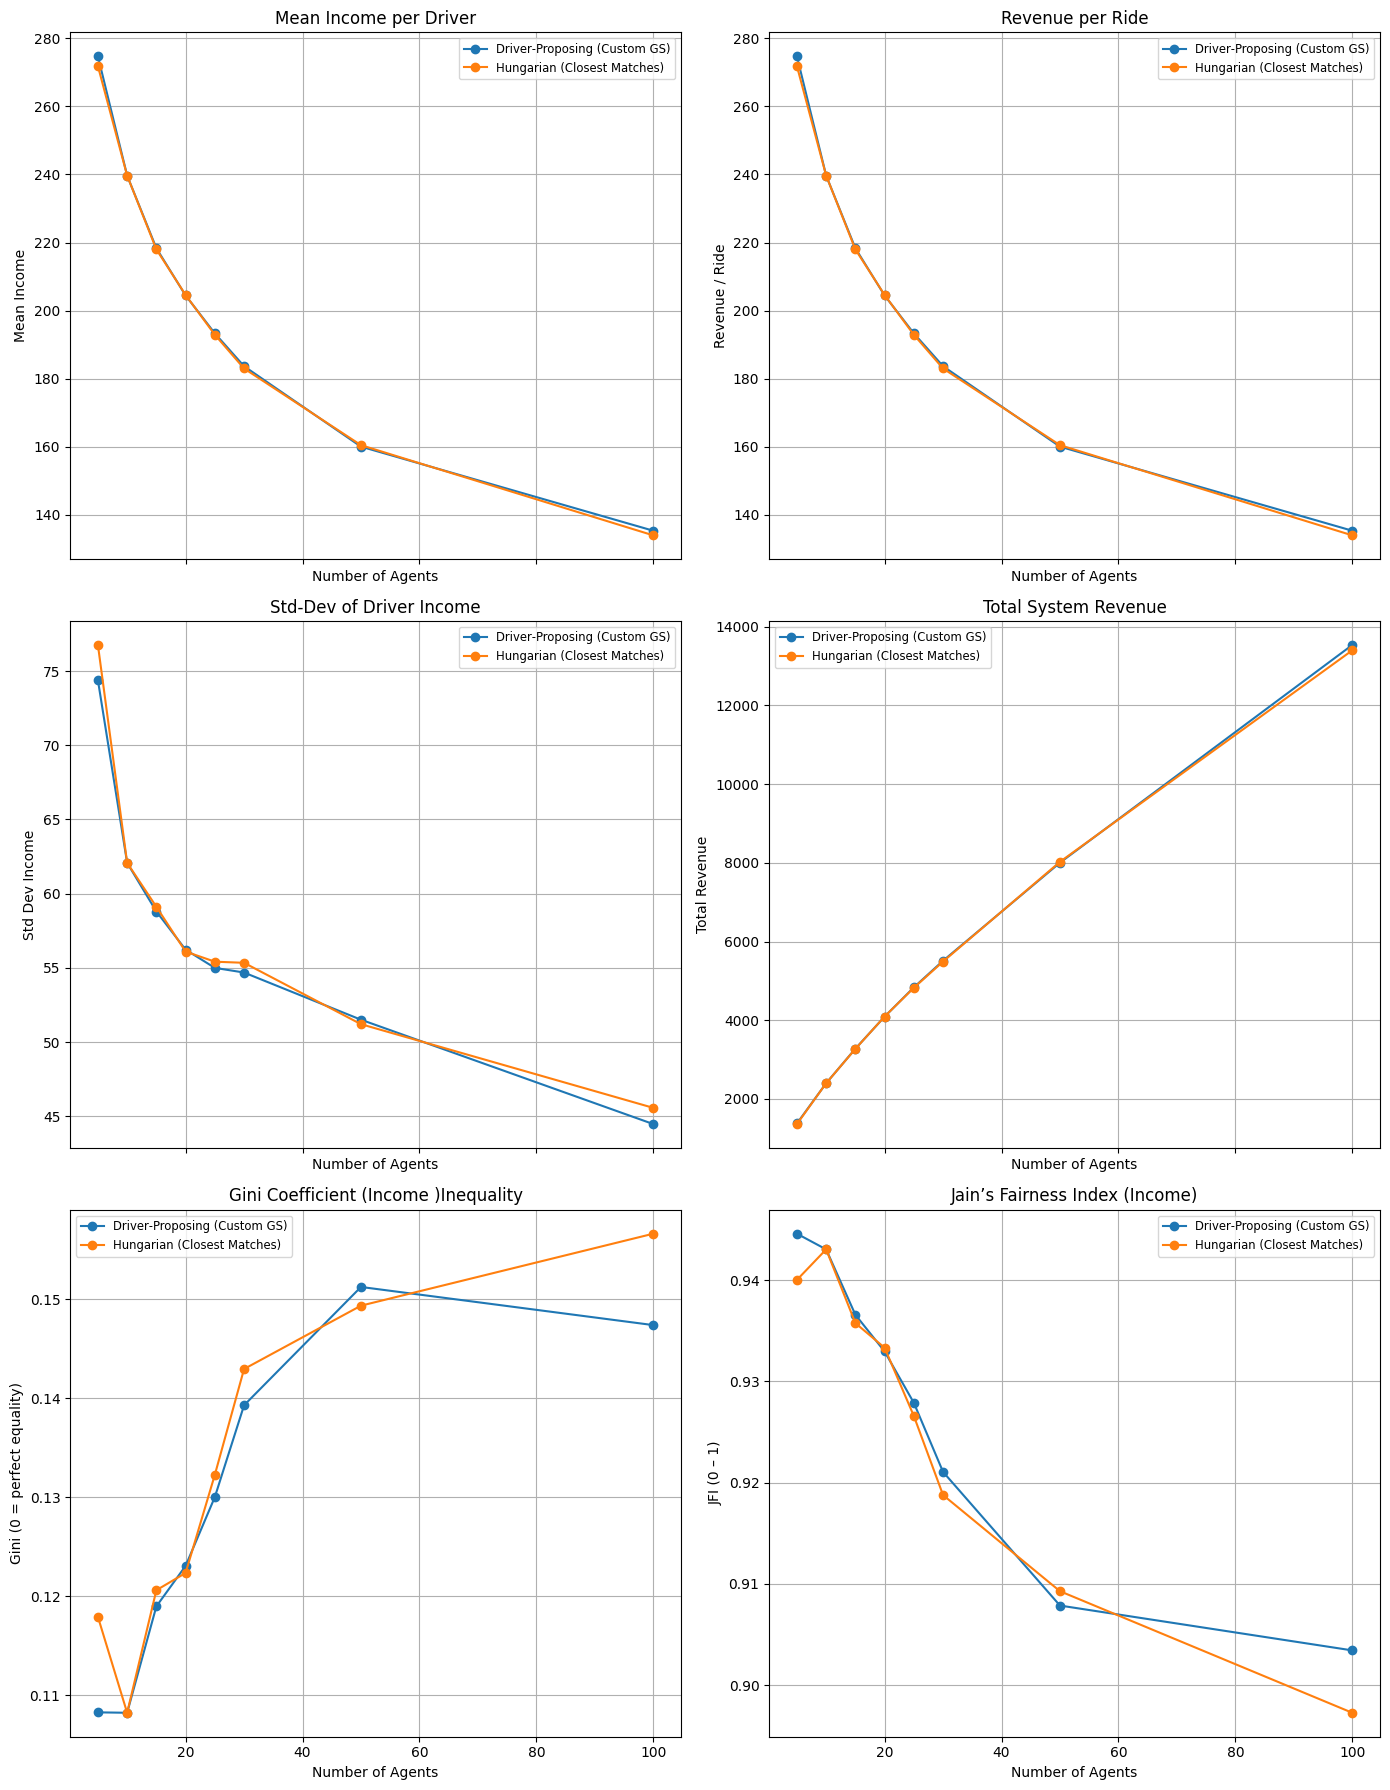

In [15]:
# 1) configure your sweep ────────────────
agent_counts = [5, 10, 15, 20, 25, 30, 50, 100]
algorithms   = {
    "Driver‑Proposing (Custom GS)": driver_proposing_matching,
    "Hungarian (Closest Matches)":  closest_matches
}

# 2) run simulations and collect metrics ─
records = []
for n in agent_counts:
    for algo_name, algo_fn in algorithms.items():
        stats = simulations(df, n, {algo_name: algo_fn},scale=0.5)[algo_name]
        records.append({
            "algorithm":        algo_name,
            "num_agents":       n,
            "total_revenue":    stats["revenue"],
            "revenue_per_ride": stats["revenue_per_ride"],
            "mean_income":      stats["mean_income"],
            "sd_income":        stats["sd_income"],
            "gini_income":      stats["gini_income"],   # NEW
            "jfi_income":       stats["jfi_income"]     # NEW
        })

df_results = pd.DataFrame(records)

# 3) plot 6 panels (2 columns × 3 rows) ───────────────────────────────
fig, axs = plt.subplots(3, 2, figsize=(14, 18), sharex=True)

for algo in df_results.algorithm.unique():
    sub = df_results[df_results.algorithm == algo]

    # top row – income & revenue
    axs[0, 0].plot(sub.num_agents, sub.mean_income,       marker="o", label=algo)
    axs[0, 1].plot(sub.num_agents, sub.revenue_per_ride,  marker="o", label=algo)

    # middle row – dispersion & system‑wide revenue
    axs[1, 0].plot(sub.num_agents, sub.sd_income,         marker="o", label=algo)
    axs[1, 1].plot(sub.num_agents, sub.total_revenue,     marker="o", label=algo)

    # bottom row – NEW fairness metrics
    axs[2, 0].plot(sub.num_agents, sub.gini_income,       marker="o", label=algo)
    axs[2, 1].plot(sub.num_agents, sub.jfi_income,        marker="o", label=algo)

# titles & axes --------------------------------------------------------
axs[0, 0].set(title="Mean Income per Driver",
              ylabel="Mean Income", xlabel="Number of Agents")
axs[0, 1].set(title="Revenue per Ride",
              ylabel="Revenue / Ride", xlabel="Number of Agents")

axs[1, 0].set(title="Std‑Dev of Driver Income",
              ylabel="Std Dev Income", xlabel="Number of Agents")
axs[1, 1].set(title="Total System Revenue",
              ylabel="Total Revenue",   xlabel="Number of Agents")

axs[2, 0].set(title="Gini Coefficient (Income )Inequality",
              ylabel="Gini (0 = perfect equality)", xlabel="Number of Agents")
axs[2, 1].set(title="Jain’s Fairness Index (Income)",
              ylabel="JFI (0 – 1)", xlabel="Number of Agents")

for ax_row in axs:
    for ax in ax_row:
        ax.grid(True)
        ax.legend(fontsize="small")

plt.tight_layout()
plt.show()
